<b>Project name:</b> Rock, Paper, Scissors, Lizard, Spock

<b>Authors:</b> Jovana Radjenovic, Zorana Aleksic

# Installation

In [ ]:
#conda install -c conda-forge keras

In [ ]:
#conda install -c conda-forge tensorflow

In [1]:
#pip install opencv-python

# Import Libraries

In [1]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn import model_selection
from matplotlib import pyplot as plt
from PIL import Image,ImageEnhance
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from time import time

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import  CategoricalCrossentropy
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Activation, Flatten, Dense, Dropout, \
                                    Convolution2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.models import load_model

In [2]:
main_directory = 'dataset'

In [3]:
class_map = {
    "rock": 0,
    "paper": 1,
    "scissors": 2,
    "lizard": 3,
    "spock": 4,
    "nothing": 5
}

# Dataset information:
- 3000 images which consist of 6 categories (each category has 600 images)
- image sizes: 300x300 and 400x380, will be resized to 300x300
<br/><br/> More info on wiki page

# Load data
Resize images to 300x300 and change color to gray.

In [4]:
dataset = []
for directory in os.listdir(main_directory):
    path = os.path.join(main_directory, directory)
    if not os.path.isdir(path):
        continue
    for item in os.listdir(path):
        # Sharpen images
        #image = Image.open("{}".format(os.path.join(path, item)))
        #enhancer = ImageEnhance.Sharpness(image)
        #image = enhancer.enhance(2)
        #image.save("{}".format(os.path.join(path, item)))
        
        image = cv2.imread(os.path.join(path, item))
        image = cv2.resize(image, (300,300))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #Code for example of efficiency when using coloured images 
        #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        dataset.append([image, directory])

# Show Examples

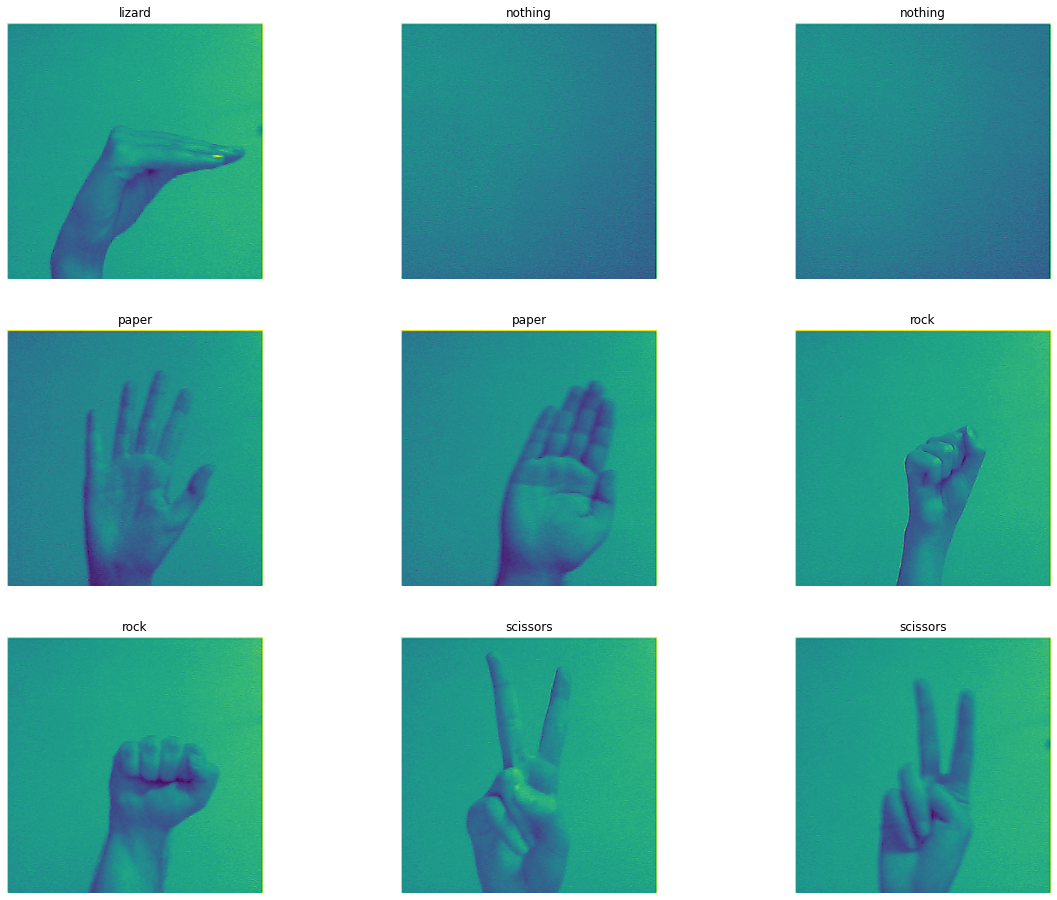

In [5]:
fig = plt.figure(figsize=(20,16))
for i in range(1, 10):
        fig.add_subplot(3, 3, i)
        image = dataset[i*333][0]
        plt.title(dataset[i*333][1])
        plt.axis('off')
        plt.imshow(image)
plt.show()

# Data preparation

Shuffle images in dataset because there are a lot of similar images one after another.

In [6]:
dataset = shuffle(dataset, random_state = 0)

Extract target variable values from dataset (Use labels to get indexes).

In [7]:
data, labels = zip(*dataset)
target = []
for label in labels:
    target.append(class_map[label])

Split data into (train + validation) data and test data.
<br/>Take 77% of the dataset to construct the (train + validation) set.
<br/>Take 33% of the dataset to construct the test set.
<br/>Use stratify to eliminate sampling bias and to choose a population that best represents the entire population being studied.

In [8]:
x_train_val, x_test, y_train_val, y_test = model_selection.train_test_split(data, target, test_size = 0.33, \
                                                                            stratify = target, random_state = 0)

Split (train + validation) data into train data and validation data.
<br/>Take 80% of the (train + validation) data to construct the train set.
<br/>Take 20% of the (train + validation) data to construct the validation set.
<br/>Use stratify to eliminate sampling bias and to choose a population that best represents the entire population being studied.

In [9]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train_val, y_train_val, test_size = 0.2, \
                                                                            stratify = y_train_val, random_state = 0)

Cast all values to 'float32' so that real values can be saved.
<br/>
Apply pixel normalization – scale values of pixels in 0-1 range

In [10]:
x_train = np.array(x_train).astype('float32') / 255
x_val = np.array(x_val).astype('float32') / 255
x_test = np.array(x_test).astype('float32') / 255

Show a visual representation of data distribution across the validation, train and test sets.

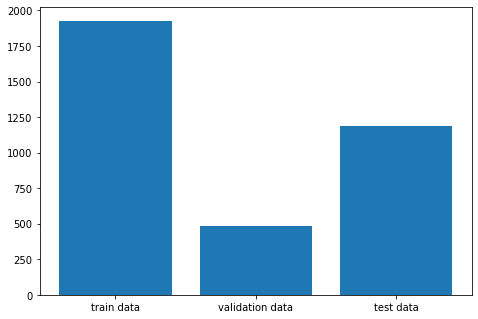

In [11]:
train_size = x_train.shape[0]
val_size=x_val.shape[0]
test_size = x_test.shape[0]
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
names = ["train data", "validation data","test data"]
sizes = [train_size,val_size, test_size]
ax.bar(names,sizes)
plt.show()

One-hot encode the labels.

In [12]:
num_of_classes = len(class_map)
y_train = utils.to_categorical(y_train, num_of_classes)
y_val = utils.to_categorical(y_val, num_of_classes)
y_test = utils.to_categorical(y_test, num_of_classes)

Keras library (and TensorFlow) use Channel last image formats.
<br/>Channel last format: (samples, height, width, color_depth).
<br/>A set of x_train.shape[0] black and white images of size 300x300 is described by a tensor of dimension (x_train.shape[0], 300, 300, 1).

In [13]:
x_train = x_train.reshape(x_train.shape[0], 300, 300, 1)
x_val = x_val.reshape(x_val.shape[0], 300, 300, 1)
x_test = x_test.reshape(x_test.shape[0], 300, 300, 1)

In [14]:
#Code for example of efficiency when using coloured images
#x_train = x_train.reshape(x_train.shape[0], 300, 300, 3)
#x_val = x_val.reshape(x_val.shape[0], 300, 300, 3)
#x_test = x_test.reshape(x_test.shape[0], 300, 300, 3)

# Initial convolutional neural network

In [13]:
model1 = Sequential([
    InputLayer(input_shape=(300,300,1)),
    Convolution2D(64, 3, activation='relu'),
    Convolution2D(32, 3, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

In [14]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 296, 296, 32)      18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 148, 148, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 700928)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               89718912  
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 7

In [15]:
model1.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [16]:
history1 = model1.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), verbose=1)

Epoch 1/10
61/61 [==============================] - 447s 7s/step - loss: 1.8838 - accuracy: 0.2789 - val_loss: 1.5881 - val_accuracy: 0.4348
Epoch 2/10
61/61 [==============================] - 439s 7s/step - loss: 1.3098 - accuracy: 0.5708 - val_loss: 0.9985 - val_accuracy: 0.7350
Epoch 3/10
61/61 [==============================] - 467s 8s/step - loss: 0.7293 - accuracy: 0.7999 - val_loss: 0.4946 - val_accuracy: 0.8986
Epoch 4/10
61/61 [==============================] - 449s 7s/step - loss: 0.3446 - accuracy: 0.9316 - val_loss: 0.2585 - val_accuracy: 0.9441
Epoch 5/10
61/61 [==============================] - 474s 8s/step - loss: 0.1835 - accuracy: 0.9637 - val_loss: 0.2081 - val_accuracy: 0.9317
Epoch 6/10
61/61 [==============================] - 445s 7s/step - loss: 0.1031 - accuracy: 0.9844 - val_loss: 0.1053 - val_accuracy: 0.9627
Epoch 7/10
61/61 [==============================] - 442s 7s/step - loss: 0.0682 - accuracy: 0.9870 - val_loss: 0.0698 - val_accuracy: 0.9834
Epoch 8/10
61

## Model evaluation and analysis

In [17]:
model1_score = model1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', model1_score[0])
print('Test accuracy:', model1_score[1])

Test loss: 0.05222589522600174
Test accuracy: 0.9873737096786499


In [18]:
classification_report_model=classification_report(np.argmax(y_test, axis=1), np.argmax(model1.predict(x_test), axis=-1))
print(classification_report_model)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       198
           1       0.94      1.00      0.97       198
           2       1.00      1.00      1.00       198
           3       1.00      1.00      1.00       198
           4       1.00      0.93      0.96       198
           5       1.00      1.00      1.00       198

    accuracy                           0.99      1188
   macro avg       0.99      0.99      0.99      1188
weighted avg       0.99      0.99      0.99      1188



In [19]:
confusion_matrix_model=confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model1.predict(x_test), axis=-1))
print(confusion_matrix_model)

[[197   1   0   0   0   0]
 [  0 198   0   0   0   0]
 [  0   0 198   0   0   0]
 [  0   0   0 198   0   0]
 [  3  11   0   0 184   0]
 [  0   0   0   0   0 198]]


In [16]:
model1 = load_model("models/model1.hdf5")

### Controversial classifications for the initial model

Spock predicted as paper

In [17]:
spock_predict_paper_model1 = (np.argmax(y_test, axis=1) == 4) & (np.argmax(model1.predict(x_test), axis=-1) == 1)

In [18]:
ind1_model1=np.where(spock_predict_paper_model1 == True)
ind1_model1

(array([ 163,  175,  374,  380,  501,  541,  590,  630,  834, 1028, 1187],
       dtype=int64),)

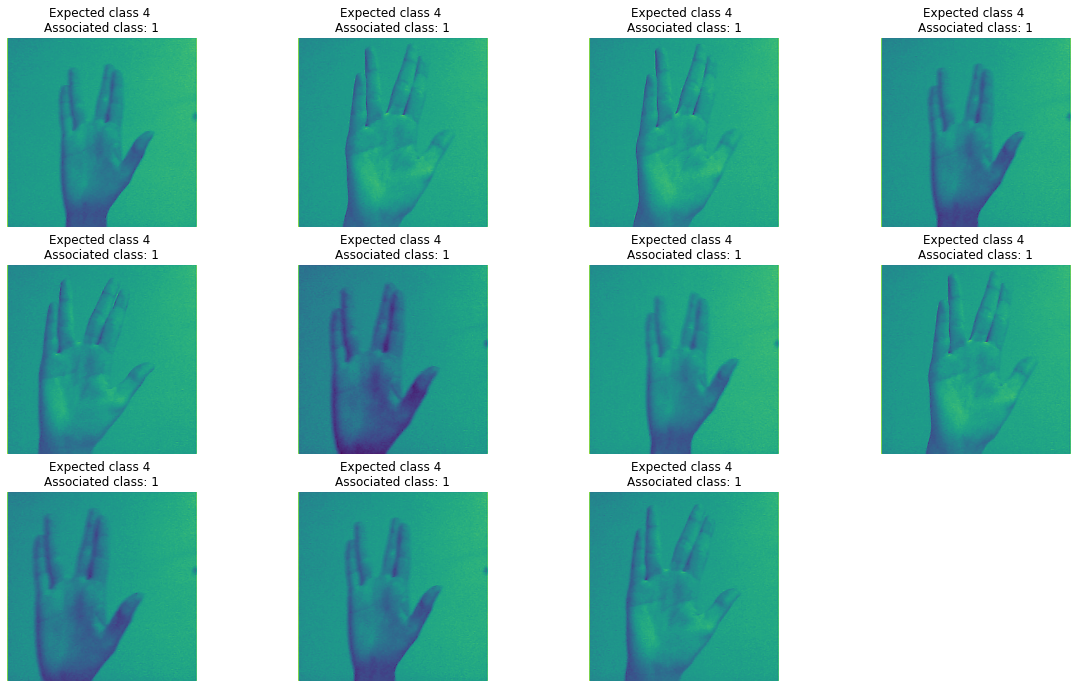

In [19]:
images = x_test[ind1_model1]
fig = plt.figure(figsize=(20,16))
for i in range(1, np.sum(spock_predict_paper_model1)+1):
        fig.add_subplot(4, 4, i)
        image = images[i-1].reshape(300,300)
        plt.title('Expected class {0} \nAssociated class: {1}'.format(4, 1))
        plt.axis('off')
        plt.imshow(image)       
plt.show()

Spock predicted as rock

In [21]:
spock_predict_rock_model1 = (np.argmax(y_test, axis=1) == 4) & (np.argmax(model1.predict(x_test), axis=-1) == 0)

In [22]:
ind2_model1=np.where(spock_predict_rock_model1 == True)

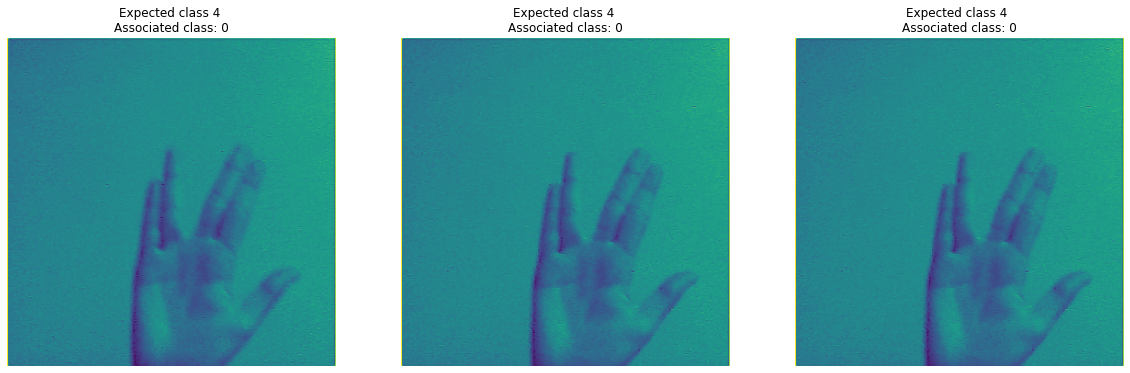

In [23]:
images = x_test[ind2_model1]
fig = plt.figure(figsize=(20,16))
for i in range(1, np.sum(spock_predict_rock_model1)+1):
        fig.add_subplot(1, 3, i)
        image = images[i-1].reshape(300,300)
        plt.title('Expected class {0} \nAssociated class: {1}'.format(4, 0))
        plt.axis('off')
        plt.imshow(image)       
plt.show()

Rock predicted as paper

In [24]:
rock_predict_paper_model1 = (np.argmax(y_test, axis=1) == 0) & (np.argmax(model1.predict(x_test), axis=-1) == 1)

In [25]:
ind3_model1=np.where(rock_predict_paper_model1 == True)

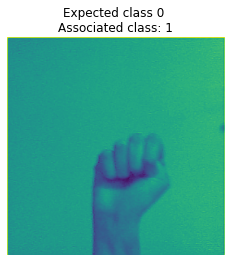

In [26]:
image = x_test[ind3_model1].reshape(300,300)
plt.title('Expected class {0} \nAssociated class: {1}'.format(0, 1))
plt.axis('off')
plt.imshow(image)       
plt.show()

## Accuracy and loss function graph

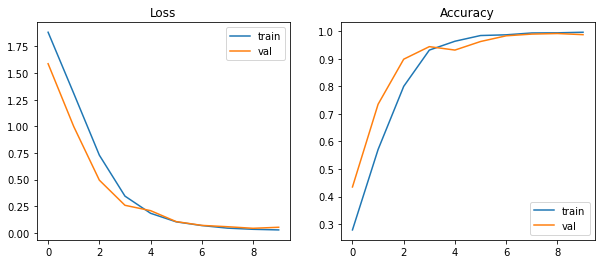

In [20]:
epochs=10
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history1.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history1.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history1.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history1.history['val_accuracy'], label='val')
plt.legend(loc='best')

plt.show()

# Save model

In [21]:
model1.save('models/model1.hdf5')

# Second convolutional neural network

In [18]:
model2 = Sequential([
    InputLayer(input_shape=(300,300,1)),
    Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

In [19]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
average_pooling2d (AveragePo (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 128)       0

In [20]:
model2.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])


In [21]:
history2 = model2.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), verbose=1)

Epoch 1/10
61/61 [==============================] - 198s 3s/step - loss: 1.7948 - accuracy: 0.2027 - val_loss: 1.7380 - val_accuracy: 0.5942
Epoch 2/10
61/61 [==============================] - 180s 3s/step - loss: 1.6420 - accuracy: 0.3681 - val_loss: 1.3414 - val_accuracy: 0.6749
Epoch 3/10
61/61 [==============================] - 181s 3s/step - loss: 1.0956 - accuracy: 0.5734 - val_loss: 0.6099 - val_accuracy: 0.8571
Epoch 4/10
61/61 [==============================] - 185s 3s/step - loss: 0.6465 - accuracy: 0.7506 - val_loss: 0.2770 - val_accuracy: 0.9337
Epoch 5/10
61/61 [==============================] - 179s 3s/step - loss: 0.4149 - accuracy: 0.8409 - val_loss: 0.1310 - val_accuracy: 0.9648
Epoch 6/10
61/61 [==============================] - 179s 3s/step - loss: 0.3301 - accuracy: 0.8694 - val_loss: 0.0920 - val_accuracy: 0.9814
Epoch 7/10
61/61 [==============================] - 179s 3s/step - loss: 0.2404 - accuracy: 0.9015 - val_loss: 0.0806 - val_accuracy: 0.9669
Epoch 8/10
61

## Model evaluation and analysis

In [22]:
model2_score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', model2_score[0])
print('Test accuracy:', model2_score[1])

Test loss: 0.029136303812265396
Test accuracy: 0.994107723236084


In [23]:
classification_report_model2=classification_report(np.argmax(y_test, axis=1), np.argmax(model2.predict(x_test), axis=-1))
print(classification_report_model2)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       198
           1       1.00      0.99      1.00       198
           2       1.00      1.00      1.00       198
           3       1.00      1.00      1.00       198
           4       0.99      0.97      0.98       198
           5       1.00      1.00      1.00       198

    accuracy                           0.99      1188
   macro avg       0.99      0.99      0.99      1188
weighted avg       0.99      0.99      0.99      1188



In [24]:
confusion_matrix_model2 = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model2.predict(x_test), axis=-1))
print(confusion_matrix_model2)

[[198   0   0   0   0   0]
 [  0 197   0   0   1   0]
 [  0   0 198   0   0   0]
 [  0   0   0 198   0   0]
 [  6   0   0   0 192   0]
 [  0   0   0   0   0 198]]


## Accuracy and loss function graph

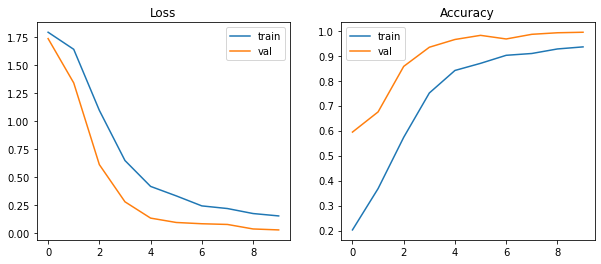

In [25]:
epochs=10
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history2.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history2.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history2.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history2.history['val_accuracy'], label='val')
plt.legend(loc='best')

plt.show()

## Save model

In [27]:
model2.save('models/model2.hdf5')

# Hyperparameter Tuning

In [ ]:
#pip install -U keras_tuner

In [22]:
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = Sequential()

    model.add(MaxPooling2D((6,6),3,input_shape=(300,300,1)))

    for i in range(hp.Int("Conv Layers", min_value=0, max_value=3)):
         model.add(Convolution2D(hp.Choice(f"layer_{i}_filters", [16,32,64]), 3, activation='relu'))
  
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.5))
    model.add(Flatten())

    model.add(Dense(hp.Choice("Dense layer", [64, 128, 256, 512, 1024]), activation='relu'))

    model.add(Dense(6, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])
  
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=32,
)

tuner.search(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)

Trial 32 Complete [00h 08m 46s]
val_accuracy: 0.9917184114456177

Best val_accuracy So Far: 1.0
Total elapsed time: 02h 51m 22s
INFO:tensorflow:Oracle triggered exit


In [23]:
best_model = tuner.get_best_models()[0]

In [24]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) (None, 99, 99, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 97, 97, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 95, 95, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 93, 93, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 46, 46, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 67712)             0

In [25]:
bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]

In [26]:
best_model = tuner.hypermodel.build(bestHP)
history_best_model = best_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), verbose=1)

Epoch 1/10
61/61 [==============================] - 84s 1s/step - loss: 1.7770 - accuracy: 0.2131 - val_loss: 1.6868 - val_accuracy: 0.3561
Epoch 2/10
61/61 [==============================] - 90s 1s/step - loss: 1.4166 - accuracy: 0.4712 - val_loss: 1.0729 - val_accuracy: 0.6025
Epoch 3/10
61/61 [==============================] - 90s 1s/step - loss: 0.8351 - accuracy: 0.7133 - val_loss: 0.6384 - val_accuracy: 0.7619
Epoch 4/10
61/61 [==============================] - 93s 2s/step - loss: 0.5238 - accuracy: 0.8263 - val_loss: 0.3624 - val_accuracy: 0.9068
Epoch 5/10
61/61 [==============================] - 92s 2s/step - loss: 0.2905 - accuracy: 0.9150 - val_loss: 0.2406 - val_accuracy: 0.9358
Epoch 6/10
61/61 [==============================] - 93s 2s/step - loss: 0.1734 - accuracy: 0.9461 - val_loss: 0.1485 - val_accuracy: 0.9545
Epoch 7/10
61/61 [==============================] - 89s 1s/step - loss: 0.0956 - accuracy: 0.9710 - val_loss: 0.0866 - val_accuracy: 0.9689
Epoch 8/10
61/61 [==

## Model evaluation and analysis

In [27]:
best_model_score = best_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', best_model_score[0])
print('Test accuracy:', best_model_score[1])

Test loss: 0.03779543563723564
Test accuracy: 0.9907407164573669


In [28]:
classification_report_best_model=classification_report(np.argmax(y_test, axis=1), np.argmax(best_model.predict(x_test), axis=-1))
print(classification_report_best_model)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       198
           1       0.97      1.00      0.99       198
           2       1.00      1.00      1.00       198
           3       1.00      1.00      1.00       198
           4       1.00      0.94      0.97       198
           5       1.00      1.00      1.00       198

    accuracy                           0.99      1188
   macro avg       0.99      0.99      0.99      1188
weighted avg       0.99      0.99      0.99      1188



In [29]:
confusion_matrix_best_model = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(best_model.predict(x_test), axis=-1))
print(confusion_matrix_best_model)

[[198   0   0   0   0   0]
 [  0 198   0   0   0   0]
 [  0   0 198   0   0   0]
 [  0   0   0 198   0   0]
 [  5   6   0   0 187   0]
 [  0   0   0   0   0 198]]


## Accuracy and loss function graph

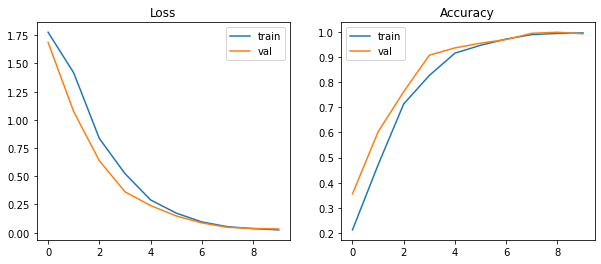

In [30]:
epochs=10
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history_best_model.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history_best_model.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history_best_model.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history_best_model.history['val_accuracy'], label='val')
plt.legend(loc='best')

plt.show()

## Save model

In [31]:
best_model.save('models/best_model.hdf5')

# AlexNet model

In [28]:
alexnet_model = Sequential()
alexnet_model.add(Convolution2D(filters=96, input_shape=(300,300,1), kernel_size=(11,11), strides=(4,4), padding='same'))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

alexnet_model.add(Convolution2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

alexnet_model.add(Convolution2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))

alexnet_model.add(Convolution2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))

alexnet_model.add(Convolution2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

alexnet_model.add(Flatten())
alexnet_model.add(Dense(4096, input_shape=(300,300,1)))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(Dropout(0.4))
alexnet_model.add(Dense(4096))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(Dropout(0.4))

alexnet_model.add(Dense(1000))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('relu'))
alexnet_model.add(Dropout(0.4))

alexnet_model.add(Dense(6))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Activation('softmax'))

In [29]:
alexnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 75, 75, 96)        11712     
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 75, 75, 96)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 38, 38, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 38, 38, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 38, 38, 256)      

In [30]:
alexnet_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [31]:
alexnet_history = alexnet_model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_val,y_val))

Epoch 1/10
16/16 [==============================] - 269s 16s/step - loss: 0.5723 - accuracy: 0.9062 - val_loss: 10.1229 - val_accuracy: 0.1677
Epoch 2/10
16/16 [==============================] - 261s 16s/step - loss: 0.3419 - accuracy: 0.9938 - val_loss: 2.3263 - val_accuracy: 0.3333
Epoch 3/10
16/16 [==============================] - 262s 16s/step - loss: 0.3246 - accuracy: 0.9979 - val_loss: 2.8148 - val_accuracy: 0.1760
Epoch 4/10
16/16 [==============================] - 262s 16s/step - loss: 0.2994 - accuracy: 1.0000 - val_loss: 3.4361 - val_accuracy: 0.1656
Epoch 5/10
16/16 [==============================] - 262s 16s/step - loss: 0.2835 - accuracy: 1.0000 - val_loss: 3.2792 - val_accuracy: 0.1656
Epoch 6/10
16/16 [==============================] - 262s 16s/step - loss: 0.2788 - accuracy: 0.9995 - val_loss: 2.6108 - val_accuracy: 0.1656
Epoch 7/10
16/16 [==============================] - 263s 16s/step - loss: 0.2709 - accuracy: 0.9984 - val_loss: 2.7496 - val_accuracy: 0.1656
Epoch

## Model evaluation and analysis

In [32]:
alexnet_model_score = alexnet_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', alexnet_model_score[0])
print('Test accuracy:', alexnet_model_score[1])

Test loss: 1.7706878185272217
Test accuracy: 0.18265993893146515


In [33]:
classification_report_alexnet_model = classification_report(np.argmax(y_test, axis=1), 
                                                            np.argmax(alexnet_model.predict(x_test), axis=-1))
print(classification_report_alexnet_model)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       198
           1       0.00      0.00      0.00       198
           2       0.00      0.00      0.00       198
           3       0.00      0.00      0.00       198
           4       1.00      0.10      0.18       198
           5       0.17      1.00      0.29       198

    accuracy                           0.18      1188
   macro avg       0.19      0.18      0.08      1188
weighted avg       0.19      0.18      0.08      1188



C:\Users\DeveloperK\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
confusion_matrix_alexnet_model = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(alexnet_model.predict(x_test), axis=-1))
print(confusion_matrix_alexnet_model)

[[  0   0   0   0   0 198]
 [  0   0   0   0   0 198]
 [  0   0   0   0   0 198]
 [  0   0   0   0   0 198]
 [  0   0   0   0  19 179]
 [  0   0   0   0   0 198]]


# Accuracy and loss function graph

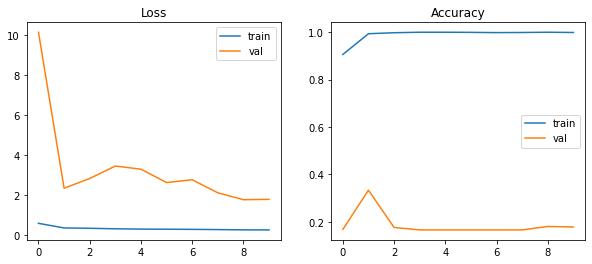

In [35]:
epochs=10
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), alexnet_history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), alexnet_history.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), alexnet_history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), alexnet_history.history['val_accuracy'], label='val')
plt.legend(loc='best')

plt.show()

## Save model

In [36]:
alexnet_model.save('models/alexnet_model.hdf5')

# Game

In [14]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from random import choice

In [15]:
class_map = {
    0: "rock",
    1: "paper",
    2: "scissors",
    3: "lizard",
    4: "spock",
    5: "nothing"
}

In [16]:
def class_name(index):
    return class_map[index]

In [17]:
def who_wins(move1, move2, player1, player2):
    if move1 == move2:
        return "Tie"

    if move1 == "rock":
        if move2 == "paper":
            return player2
        if move2 == "scissors":
            return player1
        if move2 == "lizard":
            return player1
        if move2 == "spock":
            return player2

    if move1 == "paper":
        if move2 == "rock":
            return player1
        if move2 == "scissors":
            return player2
        if move2 == "lizard":
            return player2
        if move2 == "spock":
            return player1

    if move1 == "scissors":
        if move2 == "rock":
            return player2
        if move2 == "paper":
            return player1
        if move2 == "lizard":
            return player1
        if move2 == "spock":
            return player2
        
    if move1 == "lizard":
        if move2 == "rock":
            return player2
        if move2 == "paper":
            return player1
        if move2 == "scissors":
            return player2
        if move2 == "spock":
            return player1

    if move1 == "spock":
        if move2 == "rock":
            return player1
        if move2 == "paper":
            return player2
        if move2 == "scissors":
            return player1
        if move2 == "lizard":
            return player2

In [19]:
model = load_model("models/best_model.hdf5")

In [21]:
captured_image = cv2.VideoCapture(0) # 0 -> open default camera

prev_move = None

while True:
    retval, frame = captured_image.read() # Grabs, decodes and returns the next video frame.
    if not retval:
        continue
    
    frame = cv2.flip(frame, 1)
    
    window_height = frame.shape[0]
    window_width = frame.shape[1]
    
    # rectangle for user to play
    #def: cv2.rectangle(image, start_point, end_point, color, thickness), we set color in RGB format
    cv2.rectangle(frame, (0, 0), (int(window_width * .47), int(window_height * .65)), (255, 255, 255), 2) 
    # rectangle for computer to play
    cv2.rectangle(frame, (int(window_width * .53), 0), (window_width, int(window_height * .65)), (255, 255, 255), 2)
    
    window_name = "Rock Paper Scissors Lizard Spock"
    cv2.namedWindow(window_name, cv2.WND_PROP_FULLSCREEN)
    cv2.setWindowProperty(window_name, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

    # extract the region of image within the user rectangle
    roi = frame[0:int(window_height * .60), 0:int(window_width * .40)]
    
    # sharpen image
    im_pil = Image.fromarray(roi)
    enhancer = ImageEnhance.Sharpness(im_pil)
    im_pil = enhancer.enhance(2)
    # reversing the operation:
    roi = np.asarray(im_pil)
    # sharpen image
    im_pil = Image.fromarray(roi)
    enhancer = ImageEnhance.Sharpness(im_pil)
    im_pil = enhancer.enhance(2)
    # reversing the operation:
    roi = np.asarray(im_pil)
    
    img = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (300, 300))
    
    # additional preparation of data
    img = img.reshape(300, 300, 1)
    img = np.array([img]).astype('float32')
    img /= 255
    
    # predict the move made
    pred = model.predict(img)
    move_class = np.argmax(pred[0])
    user_move_name = class_name(move_class)
    
    # predict the winner (human vs computer)
    if prev_move != user_move_name:
        if user_move_name != "nothing":
            computer_move_name = choice(['rock', 'paper', 'scissors', 'lizard', 'spock'])
            winner = who_wins(user_move_name, computer_move_name, "User", "computer")
        else:
            computer_move_name = "nothing"
            winner = "Waiting..."
    prev_move = user_move_name

    # display the information
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, "Your Move: " + user_move_name,
                (int(window_width * .05), int(window_height * .70)),
                font, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, "Computer's Move: " + computer_move_name,
                (int(window_width * .65), int(window_height * .70)),
                font, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, "Winner: " + winner,
                (int(window_width * .35), int(window_height * .90)),
                font, 0.75, (0, 0, 255), 4, cv2.LINE_AA)

    if computer_move_name != "nothing":
        icon = cv2.imread(
            "images/{}.png".format(computer_move_name))
        icon = cv2.resize(icon, (int(window_width-int(window_width * .53)), int(window_height * .65)))

        frame[0:int(window_height * .65), int(window_width * .53):window_width] = icon

    cv2.imshow(window_name, frame)

    k = cv2.waitKey(10)
    if k == ord('q'):
        break

captured_image.release()
cv2.destroyAllWindows()